In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import os
import pickle
from importlib import reload

import torch
import numpy as np
import pandas as pd
import sciplots as plots
from netloader.data import loader_init

from src import main
from src.utils import analysis, clustering, data
from src.utils.utils import open_config, overlap

reload(plots.base)
reload(plots.single_plots)
reload(plots)
reload(data)
reload(analysis)
reload(main)
reload(clustering)

import sciplots as plots
from src.utils.data import DarkDataset
from src.utils import analysis, plot_config

In [3]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = os.path.join(config['output']['plots-directory'], 'final_plots')
quantile_values = (0.5, 0.05, 0.16, 0.84, 0.95)

In [5]:
def merge_plots(plot_base, plot_append):
    plot_base._y_data = list(plot_base._y_data) if isinstance(plot_base._y_data, np.ndarray) else plot_base._y_data

    for line, poly in zip(plot_append.plots[plot_append.axes][::2], plot_append.plots[plot_append.axes][1::2]):
        line.remove()
        poly.remove()
        plot_append.plots[plot_append.axes].remove(line)
        plot_append.plots[plot_append.axes].remove(poly)

        line.set_ydata(line.get_ydata() / np.trapezoid(line.get_ydata(), np.log10(line.get_xdata())))
        verts = poly.get_paths()[0].vertices
        verts[:, 1] = verts[:, 1] / np.sum(verts[:, 1])
        poly.set_verts([verts])

        plot_append.axes.add_line(line)
        plot_append.axes.add_collection(poly)
        plot_append.plots[plot_append.axes].append(line)
        plot_append.plots[plot_append.axes].append(poly)

    for line in plot_append.plots[plot_append.axes][::2]:
        plot_base.plots[plot_base.axes].append(
            plot_base.axes.plot(*line.get_xydata().swapaxes(0, 1), color=line.get_color(), alpha=0.4, ls='-')[0])
        plot_base._data.append(line.get_xdata())
        plot_base._y_data.append(line.get_ydata())

    plot_base.axes.set_xlim(min([min(datum[y_datum > 1e-4]) for datum, y_datum in zip(plot_base._data, plot_base._y_data)]),
                            max([max(datum[y_datum > 1e-4]) for datum, y_datum in zip(plot_base._data, plot_base._y_data)]))

# BAHAMAS Tests

In [19]:
dataset = DarkDataset(
    config['data']['data-dir'],
    [
        'bahamas_cdm',
        'bahamas_cdm_low',
        'bahamas_cdm_hi',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
        'flamingo_low',
        'flamingo_hi',
        'flamingo',
        'flamingo_low_test',
    ],
    [],
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
# labels = np.array([r'$\textsc{' + label + '}$' if label.lower() != 'noise' else label for label in labels])
dataset.high_dim.shape

(40600, 3, 100, 100)

In [29]:
batch_num = 46
torch.manual_seed(0)
np.random.seed(0)
data = analysis.batch_train_summary(batch_num, '../data/')

if isinstance(data['nets'].flatten()[0], str):
    data['nets'] = data['nets'].astype(object)
    for shape in np.ndindex(data['nets'].shape):
        data['nets'][*shape] = torch.load(data['nets'][*shape], weights_only=False, map_location='cpu')

data['nets'].shape

(1, 8, 3)

In [32]:
with open(f'../data/temp_batch_predictions_{batch_num}.pkl', 'rb') as file:
    predictions = pickle.load(file)

In [20]:
predictions = analysis.gen_predictions(
    config['training']['batch-size'],
    config['training']['validation-fraction'],
    data['nets'],
    dataset,
)

Loader Dataset Lengths: [32480, 8120]
Prediction time: 3.634e+00 s
Prediction time: 3.500e+00 s
Prediction time: 3.514e+00 s
Loader Dataset Lengths: [32480, 8120]
Prediction time: 3.533e+00 s
Prediction time: 3.684e+00 s
Prediction time: 3.536e+00 s
Loader Dataset Lengths: [32480, 8120]
Prediction time: 3.496e+00 s
Prediction time: 3.496e+00 s
Prediction time: 3.497e+00 s
Loader Dataset Lengths: [32480, 8120]
Prediction time: 3.527e+00 s
Prediction time: 3.535e+00 s
Prediction time: 3.513e+00 s
Loader Dataset Lengths: [32480, 8120]
Prediction time: 3.511e+00 s
Prediction time: 3.536e+00 s
Prediction time: 3.512e+00 s
Loader Dataset Lengths: [32480, 8120]
Prediction time: 3.541e+00 s
Prediction time: 3.536e+00 s
Prediction time: 3.529e+00 s
Loader Dataset Lengths: [32480, 8120]
Prediction time: 4.022e+00 s
Prediction time: 3.532e+00 s
Prediction time: 3.536e+00 s
Loader Dataset Lengths: [32480, 8120]
Prediction time: 3.946e+00 s
Prediction time: 3.822e+00 s
Prediction time: 3.821e+00 s


In [159]:
with open(f'../data/temp_batch_predictions_{batch_num}.pkl', 'wb') as file:
    pickle.dump(predictions, file)

In [33]:
data_pred, distributions, new_distributions, grids, probs, quantiles = analysis.probs_distributions(
    quantile_values,
    predictions,
    data['nets'],
    dataset,
)
quantiles = np.concat((quantiles, [quantiles[0] - quantiles[2], quantiles[3] - quantiles[0]]), axis=0)
distributions.shape, new_distributions.shape, grids.shape, probs.shape, quantiles.shape

((1, 7, 3, 10), (1, 7, 10, 500), (1, 7, 500), (1, 7, 10, 500), (7, 1, 7, 10))

In [34]:
proj_vecs = np.empty(data_pred['latent'].shape[:-2], dtype=object)

for shape in np.ndindex(proj_vecs.shape):
    proj_vecs[*shape] = analysis.proj_all_inter_1d(data_pred['latent'][..., 1:][*shape], data_pred['targets'][*shape])

proj_vecs = np.array(proj_vecs.tolist(), dtype=object)
proj_vecs = proj_vecs.swapaxes(-2, -1)

bins = 500
cdfs = np.empty((*proj_vecs.shape, bins), dtype=float)

for shape in np.ndindex(proj_vecs.shape[:-1]):
    grid = np.mgrid[np.min(np.concat(proj_vecs[*shape])):np.max(np.concat(proj_vecs[*shape])):bins * 1j]
    cdfs[*shape] = [
        analysis.distribution_func(proj_vecs[*shape, 0], norm=True, cumulative=True, grid=grid)[1],
        analysis.distribution_func(proj_vecs[*shape, 1], norm=True, cumulative=True, grid=grid)[1],
    ]

emds = np.mean(np.subtract(cdfs[..., 0, :], cdfs[..., 1, :]), axis=-1)
overlaps = np.empty(proj_vecs.shape[:-1], dtype=float)

for shape in np.ndindex(overlaps.shape):
    overlaps[*shape] = overlap(*proj_vecs[*shape])

emd_means = np.mean(emds, axis=-3)
emd_stes = np.std(emds, axis=-3, ddof=1) / np.sqrt(emds.shape[-3])
overlap_means = np.mean(overlaps, axis=-3)
overlap_stes = np.std(overlaps, axis=-3, ddof=1) / np.sqrt(overlaps.shape[-3])
proj_vecs.shape, emd_means.shape

((1, 7, 3, 10, 9, 2), (1, 7, 10, 9))

# BAHAMAS-0.1 Unknown

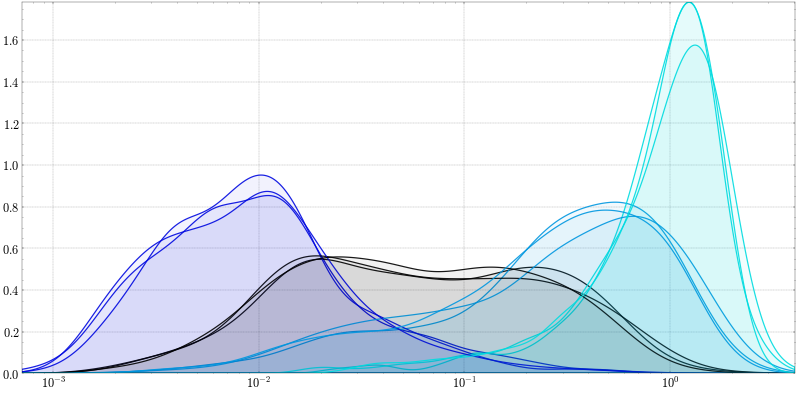

In [41]:
idx = (-1, 0)
sim_idx = np.arange(len(labels))[slice(6, None)]
colours = np.array(plot_config.BAHAMAS[:1] + ['k'] + plot_config.BAHAMAS[2:])
plot = plots.PlotDistribution(
    data['nets'][*idx, 0].transforms['targets'](distributions[*idx][:, sim_idx].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(colours, distributions.shape[-2]).tolist(),
    bins=500,
    alpha_2d=0.05,
    fig_size=(8, 4),
)

,50%,5%,16%,84%,95%,-,+
BAHAMAS-0,0.00863,0.00288,0.00430,0.01455,0.02026,0.00433,0.00592
BAHAMAS-0.1,0.04758,0.01101,0.01673,0.20554,0.35273,0.03085,0.15797
BAHAMAS-0.3,0.47430,0.12620,0.23628,0.82824,1.09447,0.23802,0.35394
BAHAMAS-1,1.19408,0.67199,0.87267,1.52388,1.75177,0.32141,0.32981


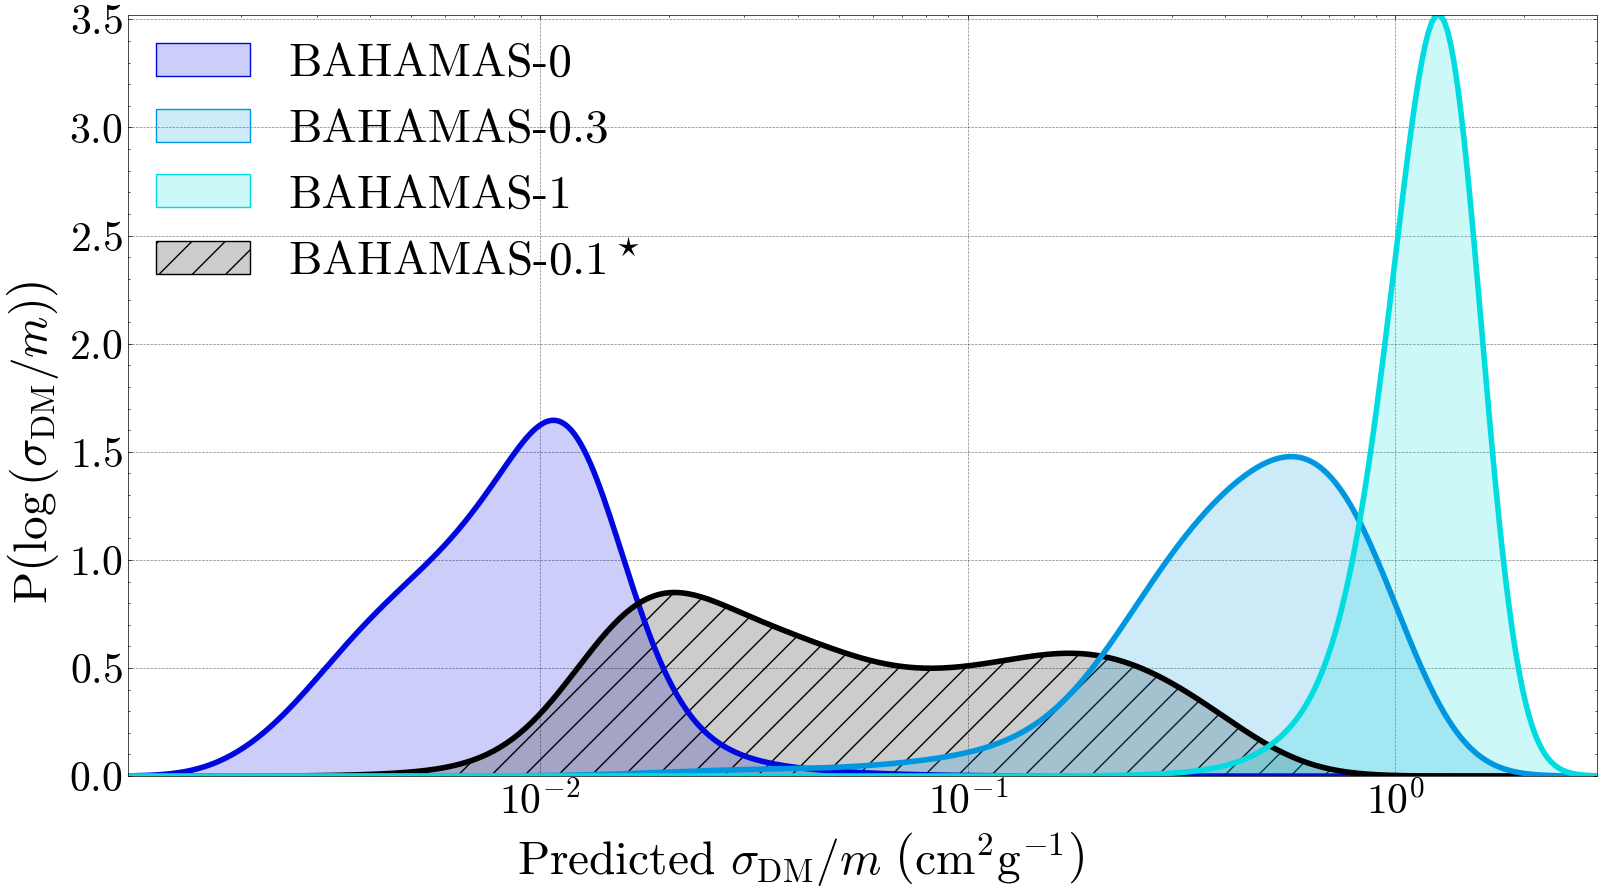

In [42]:
styles = np.array(['-'] * len(labels[sim_idx]), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(labels[sim_idx]), dtype=object)
hatches[colours == 'k'] = '/'
new_labels = labels[sim_idx].copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx, sim_idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    # styles=styles,
    styles='-',
    labels=new_labels,
    colours=colours,
    frameon=False,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    line_width=4,
    axis=True,
    cols=1,
    loc='upper left',
    label_permute=[0, 2, 3, 1],
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*idx, sim_idx]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*idx],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
# merge_plots(plot2, plot)
plot2.savefig(plots_dir, name='bahamas-0.1_distribution')
pd.DataFrame(quantiles[:, *idx, sim_idx].swapaxes(0, 1), index=labels[sim_idx], columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

,BAHAMAS-0,BAHAMAS-0.3,BAHAMAS-1
Mean,48.83,55.32,13.60
STE,0.25,0.98,0.52


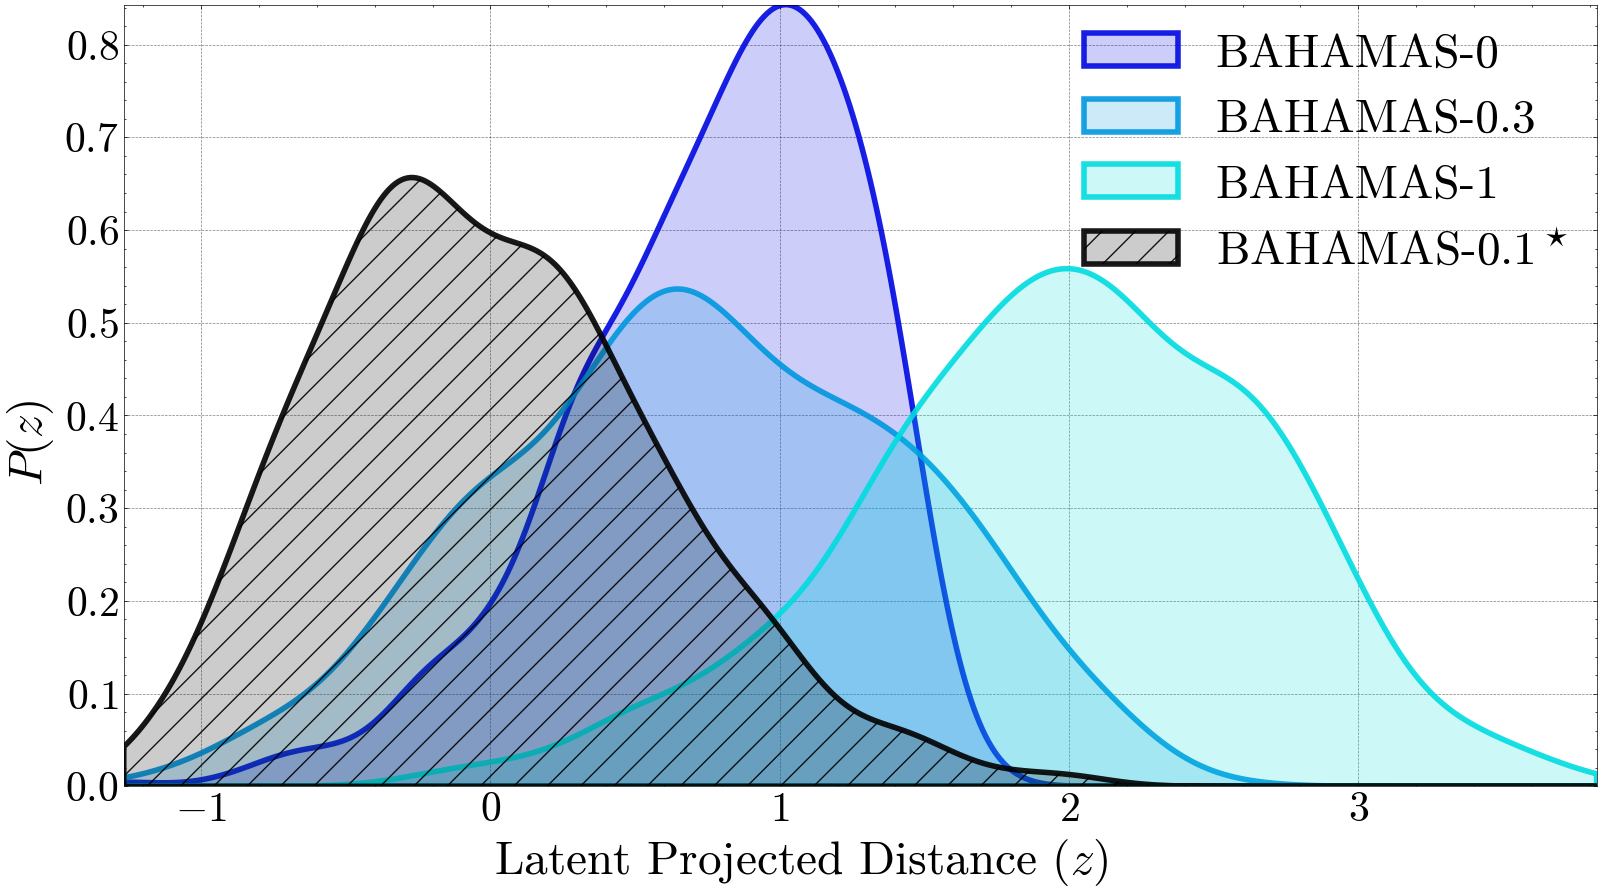

In [43]:
mmd_idx = 1
sub_sim_idx = sim_idx[sim_idx != sim_idx[mmd_idx]]
sub_sim_idx = np.where(sub_sim_idx > sim_idx[mmd_idx], sub_sim_idx - 1, sub_sim_idx)
sub_proj_vecs = proj_vecs[*idx, 0, sim_idx[mmd_idx], sub_sim_idx]

plot = plots.PlotDistribution(
    [*sub_proj_vecs[:, 1], sub_proj_vecs[1, 0]],
    y_axes=True,
    density=True,
    # norm=True,
    bins=500,
    x_labels='Latent Projected Distance $(z)$',
    y_labels='$P(z)$',
    colours=np.append(np.array(colours)[np.arange(len(colours)) != mmd_idx], colours[mmd_idx]),
    labels=np.append(new_labels[np.arange(len(new_labels)) != mmd_idx], new_labels[mmd_idx]),
    hatches=[''] * (len(new_labels) - 1) + ['/'],
    axis=True,
    frameon=False,
    cols=1,
    line_width=4,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    loc='upper right',
)
plot.savefig(plots_dir, name='bahamas-0.1_mmd')
pd.DataFrame((
    overlap_means[*idx, sim_idx[mmd_idx], sub_sim_idx],
    overlap_stes[*idx, sim_idx[mmd_idx], sub_sim_idx]),
    index=['Mean', 'STE'],
    columns=new_labels[np.arange(len(new_labels)) != mmd_idx],
).round(4) * 100

# BAHAMAS-0.3 Unknown

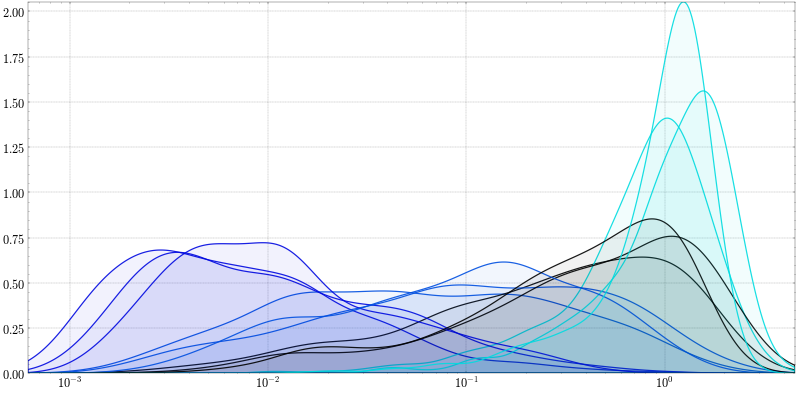

In [44]:
idx = (-1, 1)
sim_idx = np.arange(len(labels))[slice(6, None)]
colours = np.array(plot_config.BAHAMAS[:2] + ['k'] + plot_config.BAHAMAS[3:])
plot = plots.PlotDistribution(
    data['nets'][*idx, 0].transforms['targets'](distributions[*idx][:, sim_idx].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(colours, distributions.shape[-2]).tolist(),
    bins=500,
    alpha_2d=0.05,
    fig_size=(8, 4),
)

,50%,5%,16%,84%,95%,-,+
BAHAMAS-0,0.00586,0.00203,0.00286,0.01414,0.02850,0.00301,0.00828
BAHAMAS-0.1,0.11171,0.01247,0.02955,0.31681,0.55305,0.08216,0.20510
BAHAMAS-0.3,0.65014,0.13613,0.26949,1.15552,1.51306,0.38065,0.50538
BAHAMAS-1,1.17648,0.66193,0.86675,1.54050,1.81096,0.30973,0.36403


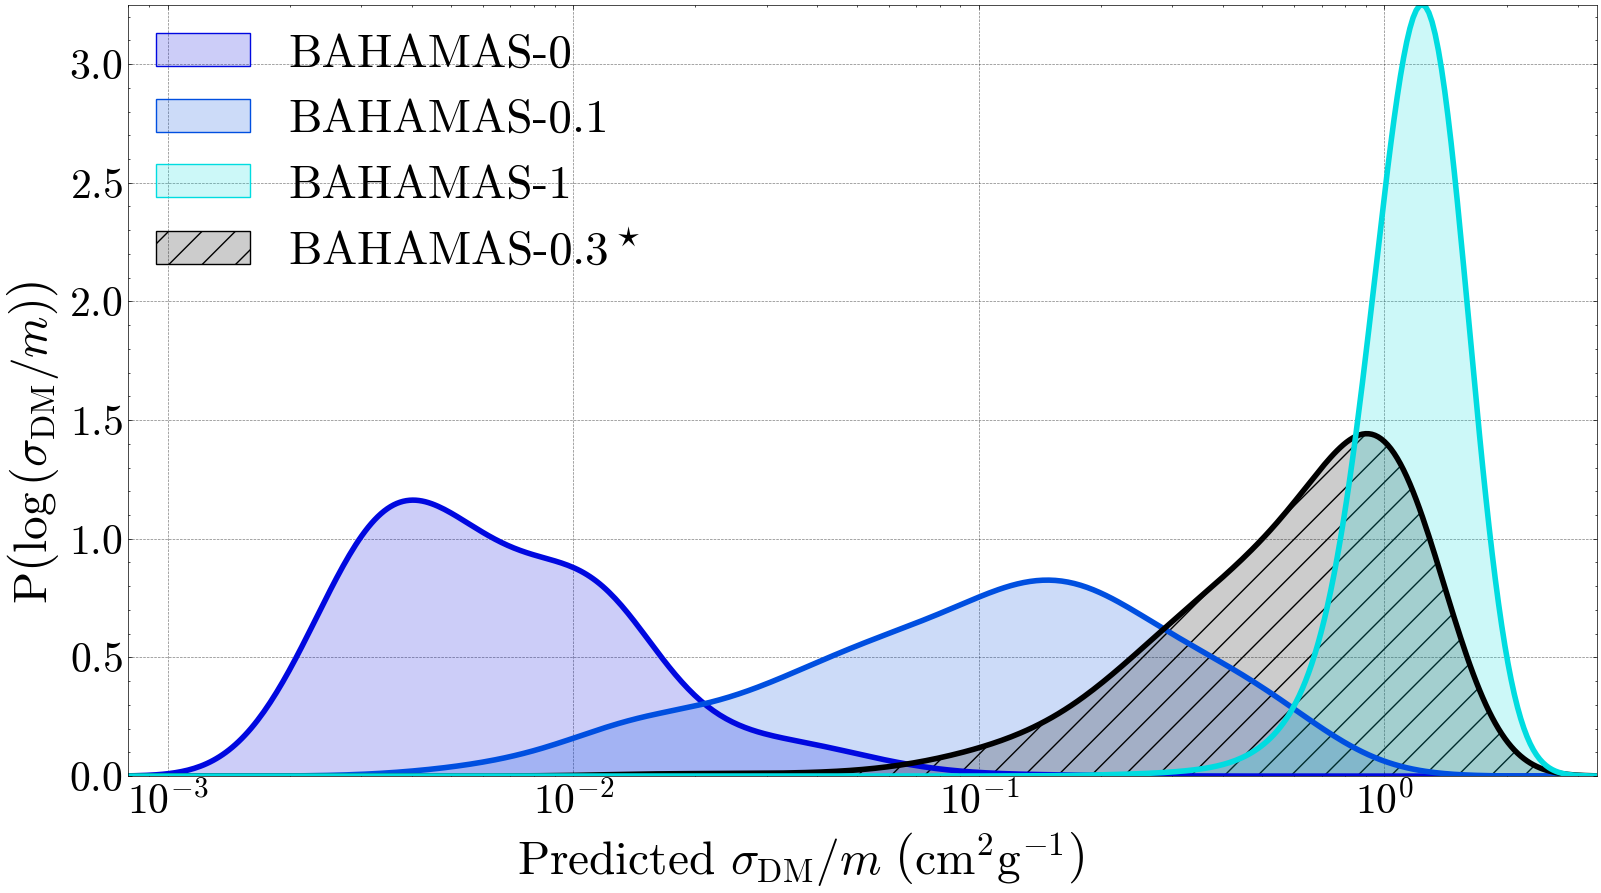

In [45]:
styles = np.array(['-'] * len(labels[sim_idx]), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(labels[sim_idx]), dtype=object)
hatches[colours == 'k'] = '/'
new_labels = labels[sim_idx].copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx, sim_idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    # styles=styles,
    styles='-',
    labels=new_labels,
    colours=colours,
    frameon=False,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    line_width=4,
    axis=True,
    cols=1,
    loc='upper left',
    label_permute=[0, 1, 3, 2],
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*idx, sim_idx]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*idx],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
# merge_plots(plot2, plot)
plot2.savefig(plots_dir, name='bahamas-0.1_distribution')
pd.DataFrame(quantiles[:, *idx, sim_idx].swapaxes(0, 1), index=labels[sim_idx], columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

,BAHAMAS-0,BAHAMAS-0.1,BAHAMAS-1
Mean,24.76,59.88,38.11
STE,0.19,0.34,1.32


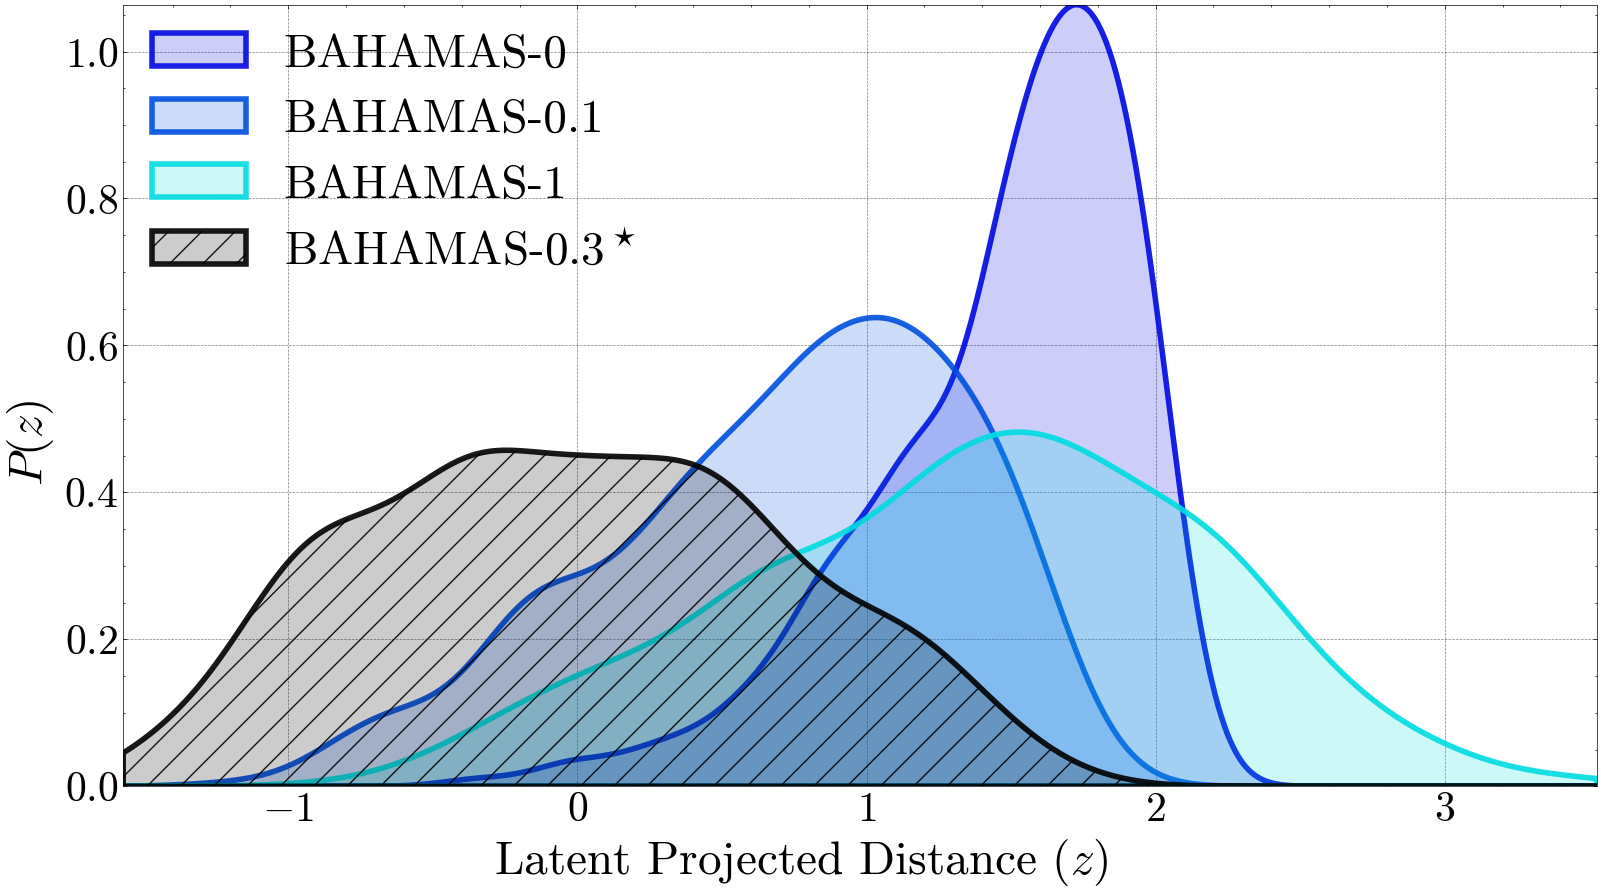

In [46]:
mmd_idx = 2
sub_sim_idx = sim_idx[sim_idx != sim_idx[mmd_idx]]
sub_sim_idx = np.where(sub_sim_idx > sim_idx[mmd_idx], sub_sim_idx - 1, sub_sim_idx)
sub_proj_vecs = proj_vecs[*idx, 0, sim_idx[mmd_idx], sub_sim_idx]

plot = plots.PlotDistribution(
    [*sub_proj_vecs[:, 1], sub_proj_vecs[1, 0]],
    y_axes=True,
    density=True,
    # norm=True,
    bins=500,
    x_labels='Latent Projected Distance $(z)$',
    y_labels='$P(z)$',
    colours=np.append(np.array(colours)[np.arange(len(colours)) != mmd_idx], colours[mmd_idx]),
    labels=np.append(new_labels[np.arange(len(new_labels)) != mmd_idx], new_labels[mmd_idx]),
    hatches=[''] * (len(new_labels) - 1) + ['/'],
    axis=True,
    frameon=False,
    cols=1,
    line_width=4,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    loc='upper left',
)
plot.savefig(plots_dir, name='bahamas-0.1_mmd')
pd.DataFrame((overlap_means[*idx, sim_idx[mmd_idx], sub_sim_idx], overlap_stes[*idx, sim_idx[mmd_idx], sub_sim_idx]), index=['Mean', 'STE'], columns=new_labels[np.arange(len(new_labels)) != mmd_idx]).round(4) * 100

# BAHAMAS AGN Unknown

,50%,5%,16%,84%,95%,-,+
BAHAMAS-0w,0.00670,0.00126,0.00226,0.01876,0.04205,0.00445,0.01206
BAHAMAS-0s,0.01253,0.00200,0.00439,0.02866,0.05466,0.00814,0.01613
BAHAMAS-0,0.01110,0.00208,0.00405,0.02342,0.05250,0.00705,0.01232
BAHAMAS-0.1,0.13017,0.02925,0.05926,0.25848,0.37925,0.07091,0.12832
BAHAMAS-0.3,0.41951,0.15297,0.23844,0.69472,0.94026,0.18107,0.27521
BAHAMAS-1,1.19785,0.64085,0.86736,1.52601,1.72240,0.33049,0.32815


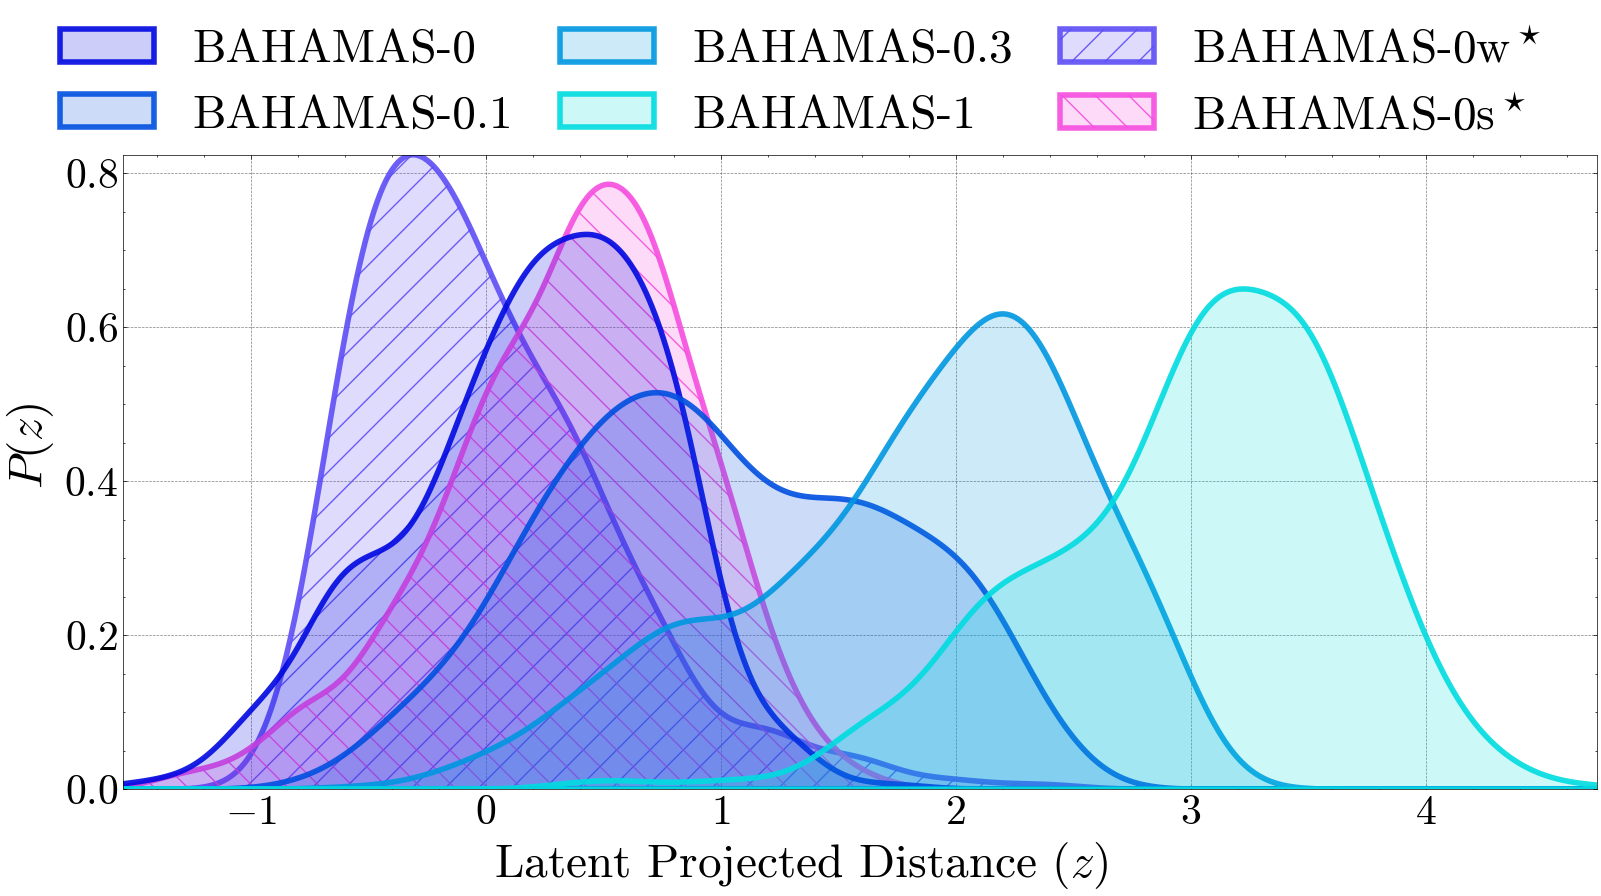

In [47]:
idx = (0, 2)
sim_idx = np.arange(len(labels))[slice(4, None)]
colours = plot_config.BAHAMAS_AGN + plot_config.BAHAMAS
mmd_idx = 0
sub_sim_idx = sim_idx[sim_idx != sim_idx[mmd_idx]]
sub_sim_idx = np.where(sub_sim_idx > sim_idx[mmd_idx], sub_sim_idx - 1, sub_sim_idx)
sub_proj_vecs = proj_vecs[*idx, 0, sim_idx[mmd_idx], sub_sim_idx]
new_labels = labels[sim_idx].copy().astype(object)
new_labels[:2] = new_labels[:2] + rf'$^\star$'

plot = plots.PlotDistribution(
    [sub_proj_vecs[2, 0], *sub_proj_vecs[:, 1]],
    density=True,
    # norm=True,
    y_axes=True,
    bins=500,
    x_labels='Latent Projected Distance $(z)$',
    y_labels='$P(z)$',
    colours=np.append(colours[mmd_idx], np.array(colours)[np.arange(len(colours)) != mmd_idx]),
    labels=np.append(new_labels[mmd_idx], new_labels[np.arange(len(new_labels)) != mmd_idx]),
    hatches=['/'] + ['\\'] + [''] * (len(labels[sim_idx]) - 2),
    frameon=False,
    cols=3,
    line_width=4,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    columnspacing=1,
    label_permute=[2, 3, 4, 5, 0, 1],
)
plot.savefig(plots_dir, name='bahamas_agn_mmd')
pd.DataFrame(quantiles[:, *idx[:2], sim_idx].swapaxes(0, 1), index=labels[sim_idx], columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

In [48]:
print(pd.DataFrame((
    overlap_means[*idx, sim_idx[mmd_idx], sub_sim_idx],
    overlap_stes[*idx, sim_idx[mmd_idx], sub_sim_idx]),
    index=['Mean', 'STE'],
    columns=new_labels[np.arange(len(new_labels)) != mmd_idx],
).round(4) * 100)
mmd_idx = 1
pd.DataFrame((
    overlap_means[*idx, sim_idx[mmd_idx], sub_sim_idx],
    overlap_stes[*idx, sim_idx[mmd_idx], sub_sim_idx]),
    index=['Mean', 'STE'],
    columns=new_labels[np.arange(len(new_labels)) != mmd_idx],
).round(4) * 100

      BAHAMAS-0s$^\star$  BAHAMAS-0  BAHAMAS-0.1  BAHAMAS-0.3  BAHAMAS-1
Mean               77.09      83.86        44.21        21.12       3.85
STE                 0.74       0.63         1.23         1.20       0.39


,BAHAMAS-0w$^\star$,BAHAMAS-0,BAHAMAS-0.1,BAHAMAS-0.3,BAHAMAS-1
Mean,77.09,90.13,46.31,22.35,3.66
STE,0.74,1.31,0.88,0.66,0.05
